# Setup instructions

---

## Creating a virtual environment (if running locally)

1. Open the terminal in the folder where this file is and run `python -m <venv name> <path for venv folder>`
   For e.g. I ran `python -m venv .\venv` and it is important to note that the `.\venv` folder did not exist before I ran the command but I have to specify the name of the folder of venv
2. Once the virtual env folder is created, execute the command `<venv folder name>\Scripts\activate` to activate the virtual environment

## Installing requirements

In your terminal make sure that you are in this directory where this `requiurements.txt` is present and execute `pip install -r requirements.txt`

## IBM API token

Assuming that you have `python-dotenv` installed by now, if the above steps were completed without any errors, create a `.env` file in this directory and in it specify your key in the following format `IBM_API_KEY=your_long_ibm_api_key`

You can get the key by logging into your IBM account at [IBM Quantum Website](https://quantum.ibm.com/) and on the top right corner you should be able to see your api token (Refer below image)

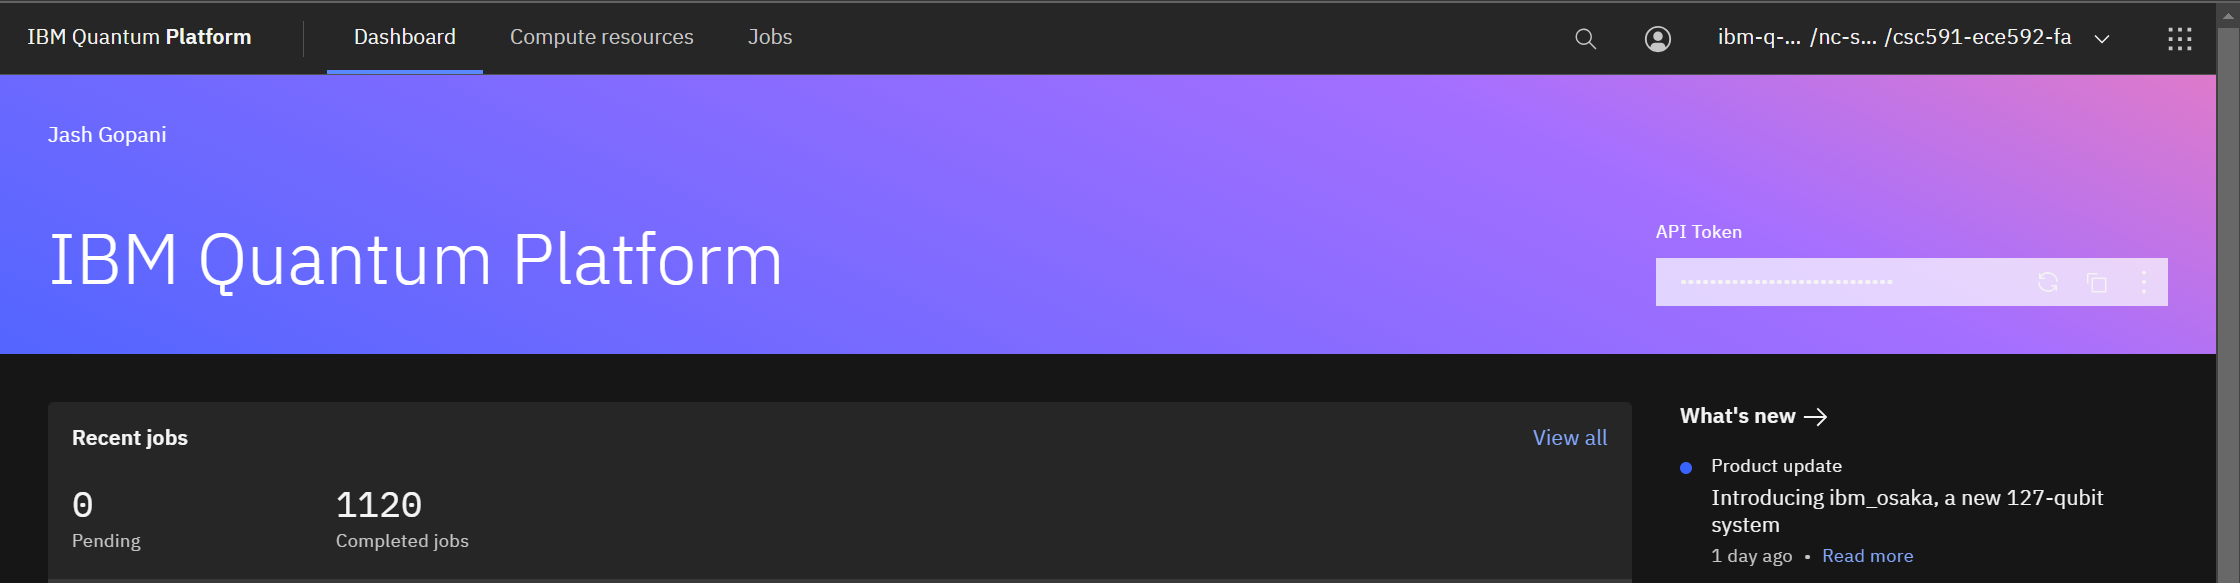


# Imports and IBM account connection setup


In [2]:
# General imports
import numpy as np
import os
import random
from dotenv import load_dotenv

# Plotting functions
import matplotlib.pyplot as plt
import networkx as nx

# SciPy minimizer routine
from scipy.optimize import minimize

# Qiskit imports
from qiskit import IBMQ, execute, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService,  Session, Options
from qiskit.primitives import Estimator
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import EfficientSU2, TwoLocal

If the below cell gives an error that account is already saved then it is fine


In [ ]:
load_dotenv()
IBMProvider.save_account(os.getenv('IBM_API_KEY'))

In [4]:
# Setup account and backend service
provider = IBMProvider()
service = QiskitRuntimeService()

# The problem statement

There is an event scheduling organization who has events on weekends. All of the events are a day long, so it is not possible for a participant to attend more than one event in a day. To maximize the attendance, the company has asked all the participants to submit their preferences for which two events they wish to attend. Our task is to schedule the events such that it maximizes the participation based on the preferences.


**Reference** - [https://youtu.be/LhbDMv3iA9s](https://youtu.be/LhbDMv3iA9s)


# Visualizing the problem

This problem can be visualized as a graph problem with the events being the nodes of the graph, the edges being the user preferences i.e a connection between the two events that a participant wants to attend. The weight of the edge being the number of participants that have the same preference. 
Our goal is to decide which event is to be scheduled on saturday and which on sunday. For this, we can think of assigning a "0" or "1" value to the nodes, i.e. 0 if it is to be scheduled on a saturday and 1 if it is to be scheduled on Sunday.
This idea of assigning 0 or 1 is equivalent to partitioning the graph and in such a way that maximum edges are cut i.e. maximum preferences are taken into consideration. This is why, this problem is a Max Cut problem.

# Implementation Starts here

All the methods are defined first then the graph is created and classical and quantum algorithms are executed

The code from this [Qiskit demo article](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver) is used as a base template for this implementation

Other references

-   [https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html](https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html)


In [35]:
# Computing the weight matrix from the random graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600,
                     alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def print_explanation(bit_string, cost):
    weekend = {'0':[],'1':[]}
    for index in range(len(bit_string)):
        char = bit_string[index]
        weekend[char].append(str(index))
    print("The events will be scheduled as follows")
    print(f"Saturday: {', '.join(weekend['0'])}")
    print(f"Sunday: {', '.join(weekend['1'])}")
    print(f"Expected No. of participants: {cost}")

# The Graph

For demonstration purpose, consider the following scenario

**n**: number of events

**list_edges**: list of tuples with the first two values being the event number and third value is the count of participants that have that preference


Number of participants:  100


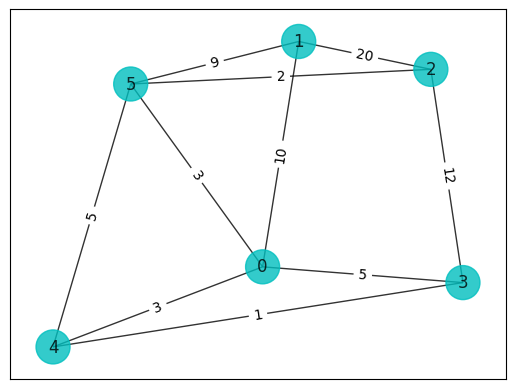

In [14]:
# Defining a graph
n = 6
list_edges = [(0, 1,10), (1, 2,20), (2, 5,30),
              (0, 3,5), (1, 5,9), (3, 4,1),
              (0, 4,3), (2, 3,12), (4, 5,5),
              (0, 5,3), (2, 5,2)]
num_participants = sum([t[2] for t in list_edges])
print('Number of participants: ',num_participants)
G = nx.Graph()
G.add_weighted_edges_from(list_edges)
colors = ["c" for i in range(n)]
draw_graph(G, colors, nx.spring_layout(G))
plt.show()

# Classic Brute Force Calculation


The events will be scheduled as follows
Saturday: 0, 2, 5
Sunday: 1, 3, 4
Expected No. of participants: 64.0


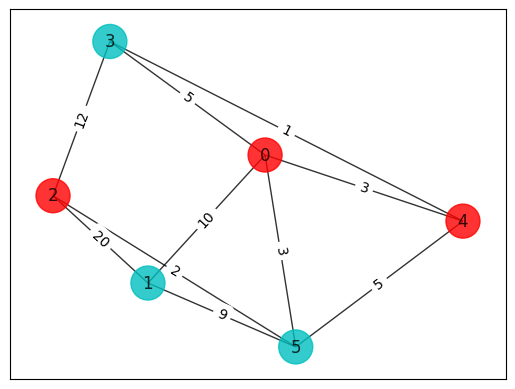

In [36]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        best_event_schedule = x
    # print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if best_event_schedule[i] == 0 else "c" for i in range(n)]
print_explanation("".join(map(str,best_event_schedule)),best_cost_brute)
draw_graph(G, colors, nx.spring_layout(G))

In [38]:
def draw_circuit(qc: QuantumCircuit):
    qc.draw(output='mpl', style='clifford')

In [39]:
def add_hwe_ansatz(qc: QuantumCircuit, repetation_count=2) -> QuantumCircuit:
    n = qc.num_qubits
    theta, phi = Parameter('theta'), Parameter('phi')

    for _ in range(repetation_count):
        for i in range(n):
            qc.rx(theta, i)
            qc.ry(phi, i)

        for i in range(n-1):
            qc.cx(i, i+1)

In [40]:
def add_ry_ansatz(qc: QuantumCircuit, repetation_count=2) -> QuantumCircuit:
    n = qc.num_qubits
    theta = Parameter('theta')

    for i in range(n):
        qc.ry(theta, i)

In [41]:
def identity_pauli_string(n):
    return ["I" for _ in range(n)]

In [37]:
def get_pauli_strings_from_graph(sparse_graph_list, n):
    pauli_strings = []
    for (x, y, w) in sparse_graph_list:
        temp_pauli_string_arr = identity_pauli_string(n)
        temp_pauli_string_arr[x] = temp_pauli_string_arr[y] = "Z"
        pauli_strings.append(("".join(temp_pauli_string_arr),w))

    return list(set(pauli_strings))

In [42]:
def generate_random_param_values(num_params):
    return [random.uniform(-2*np.pi, 2*np.pi) for _ in range(num_params)]

In [43]:
def cost_func(params, ansatz, hamiltonian, estimator, intermediate_data, num_params, print_debug_info=False):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Flattened Array of ansatz parameters
        ansatz (QuantumCircuit): Array of Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        intermediate_data (Dict): mutable object to store intermediate data
        num_params (int): Number of parameters in circuit
        print_debug_info (Boolean): Whether to print each iteration's information (False by default)
    Returns:
        float: Energy estimate
    """

    # perform cost calculation
    energy = sum(estimator.run(ansatz, hamiltonian,
                 parameter_values=params).result().values)

    # update data for analysis
    intermediate_data["params_history"].append(params)
    intermediate_data['iters'] += 1
    intermediate_data["cost_history"].append(energy)
    if (print_debug_info):
        print("Iters. done: {}, Params: {}, Current cost: {}".format(
            intermediate_data["iters"], params, energy))
    return energy

[('ZZIIII', 10), ('IIIIZZ', 5), ('ZIIIIZ', 3), ('IIZIIZ', 2), ('ZIIIZI', 3), ('IIIZZI', 1), ('IIZIIZ', 30), ('IIZZII', 12), ('IZZIII', 20), ('IZIIIZ', 9), ('ZIIZII', 5)]
num_params 24


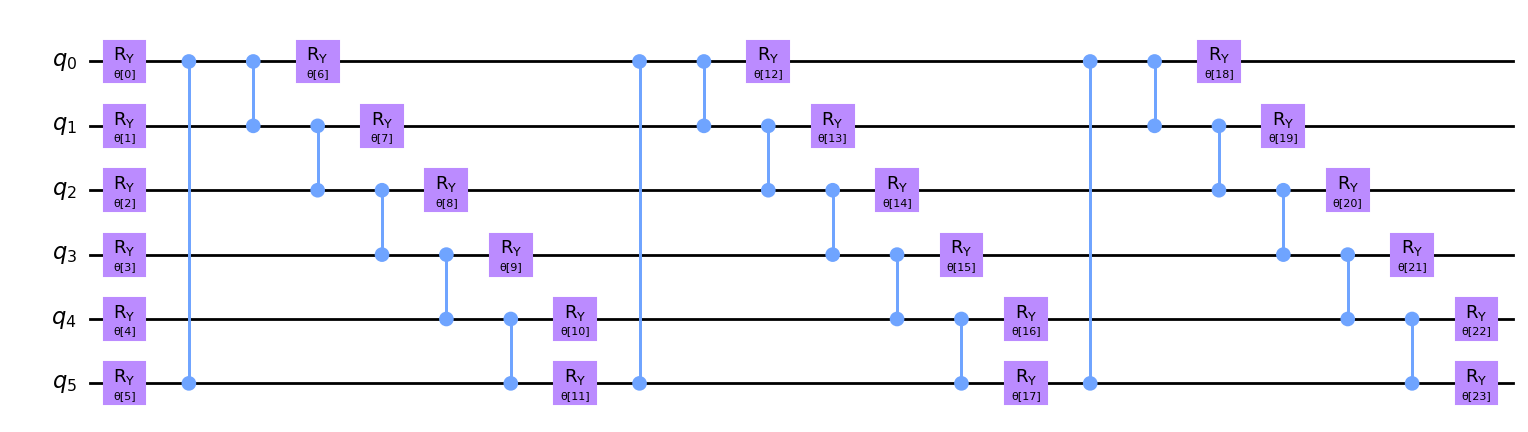

In [55]:
# Using TwoLocal ansatz (arbitrary choice)
ansatz_qc = TwoLocal(n, "ry", "cz", reps=n//2, entanglement='circular')
ansatz_qc = ansatz_qc.decompose()
num_params = ansatz_qc.num_parameters
pauli_strings = get_pauli_strings_from_graph(list_edges, n)
hamiltonian_arr = SparsePauliOp.from_list(pauli_strings)

print(pauli_strings)
print('num_params', num_params)
ansatz_qc.draw(output='mpl', style='clifford')

# Using **ibmq_qasm_simulator**

Run this cell to execute VQE on IBM server


In [ ]:
# Code to run on ibm-runtime-simulator
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 100000

intermediate_data = {
    "params_history": [],
    "iters": 0,
    "cost_history": [],
}

with Session(backend="qasm_simulator") as session:
    estimator = Estimator()
    res = minimize(
        fun=cost_func,
        x0=generate_random_param_values(num_params),
        args=(ansatz_qc, hamiltonian_arr, estimator,
              intermediate_data, num_params),
        method="cobyla",
    )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(
    intermediate_data['iters'], intermediate_data['cost_history'][-1], intermediate_data['params_history'][-1]))
print('res', res)

# Using Aer Simulator backend

Alternatively run this cell to run the algorithm locally


In [ ]:
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit_aer.primitives import Estimator as AerEstimator

intermediate_data = {
    "params_history": [],
    "iters": 0,
    "cost_history": [],
}
# print(hamiltonian_arr)


with Session(backend=Aer.get_backend('aer_simulator')) as session:
    estimator = AerEstimator(run_options={'shots': 100000})
    res = minimize(
        fun=cost_func,
        x0=generate_random_param_values(num_params),
        args=(ansatz_qc, hamiltonian_arr, estimator,
              intermediate_data, num_params, True),
        method="cobyla",
    )

print('\nintermediate_data [#iterations: {} , cost: {}, params:{}]'.format(
    intermediate_data['iters'], intermediate_data['cost_history'][-1], intermediate_data['params_history'][-1]))
print('res', res)

# Using final parameters to get the state vector

Irrespective of whether you ran the VQE on IBM server or locally, the below cells would help you visualize the results


optimal parameters [ 9.78925653e-01 -2.70684767e+00  1.31249178e+00  4.91638883e+00
  3.02855848e+00  7.28518423e-01 -6.29047667e+00 -1.00626371e-03
 -3.14051102e+00 -1.95241705e+00  3.58479734e+00  3.93126223e+00
 -1.12193337e+00 -2.70469277e+00 -4.81259013e+00 -3.36043807e+00
  3.14435333e+00  6.27871781e+00  1.27469440e+00 -6.60188695e-03
 -5.10919091e+00  1.80833062e+00  4.35513847e-01  3.80510229e+00]
{'010101': 9987, '101000': 11, '101001': 1, '101100': 1}


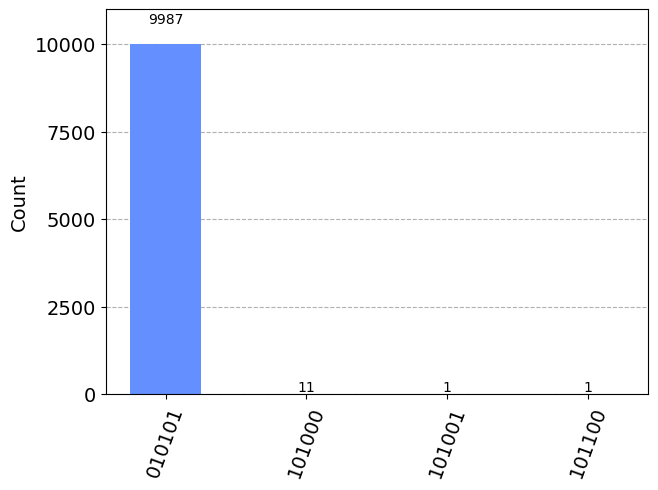

In [65]:
# Use Aer simulator backend
from qiskit.visualization import plot_state_city
aer_backend = Aer.get_backend('aer_simulator')


print('optimal parameters', intermediate_data['params_history'][-1])

# Transpile the circuit for the simulator
t_ansatz_qc = QuantumCircuit(n, n)
t_ansatz_qc.compose(ansatz_qc, inplace=True)
t_ansatz_qc = t_ansatz_qc.assign_parameters(
    intermediate_data['params_history'][-1])
t_ansatz_qc.barrier()
t_ansatz_qc.measure_all(add_bits=False)


backend = service.get_backend('simulator_mps')
result = aer_backend.run(t_ansatz_qc, shots=10000).result()

# Get the final state
final_state = result.get_counts()

# t_ansatz_qc.draw(output='mpl', style='clifford')
print(final_state)
plot_histogram(final_state)

# Visualizing Parameters and convergence

We can also now view the progress towards convergence as monitored by the cost history at each iteration:


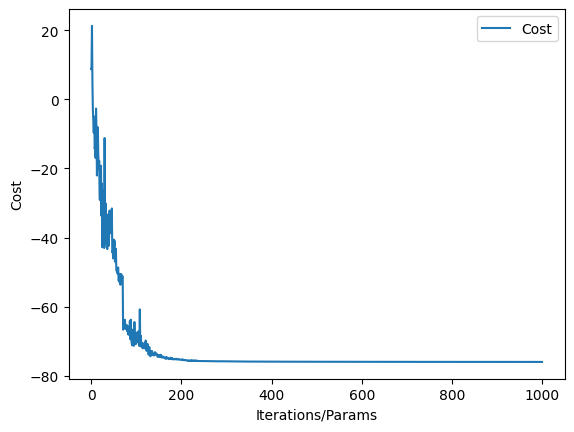

In [66]:
fig, ax = plt.subplots()
# Extracting parameter value history from the 2D array using zip(*two_d_array)
transposed_array = list(zip(*intermediate_data['params_history']))
column_lists = [list(column) for column in transposed_array]

# To avoid the graph becoming messy
if(num_params < 5):
    for i, p in enumerate(column_lists):
        ax.plot(p, label='Param {}'.format(i))

ax.plot(range(intermediate_data['iters']),
        intermediate_data['cost_history'], label='Cost')
ax.set_xlabel("Iterations/Params")
ax.set_ylabel("Cost")

plt.legend()
plt.draw()